In [79]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [93]:
def format_large_numbers(x, pos):
    if np.abs(x) >= 1e9:
        return f'{x * 1e-9:.1f}B'  # Format as Billion
    elif np.abs(x) >= 1e6:
        return f'{x * 1e-6:.1f}M'  # Format as Million
    elif np.abs(x) >= 1e3:
        return f'{x * 1e-3:.1f}K'  # Format as Thousand
    else:
        return f'{x:.0f}'  # Less than 1,000

In [81]:
tvl_data = ['data/algorand.csv', 'data/aptos.csv', 'data/bitcoin.csv',
            'data/cardano.csv', 'data/icp.csv', 'data/near.csv',
            'data/sei.csv', 'data/solana.csv', 'data/sui.csv',
            'data/tezos.csv']

price_data = ['price/algo_usd.csv', 'price/apt_usd.csv', 'price/btc_usd.csv',
              'price/ada_usd.csv', 'price/icp_usd.csv', 'price/near_usd.csv',
              'price/sei_usd.csv', 'price/sol_usd.csv', 'price/sui_usd.csv',
              'price/xtz_usd.csv']

chain_names = ['Algorand', 'Aptos', 'Bitcoin',
               'Cardano', 'ICP', 'NEAR',
               'Sei', 'Solana', 'Sui',
               'Tezos']

In [82]:
def get_tvl(chain : str , tvl_file : str):
    """
    Input: string and csv
    Output: dataframe with the defined format
    """
    df = pd.read_csv(tvl_file)

    protocol_name = df.columns[0]
    tvl_column = 'Total'

    #Transpose dates into rows 
    df_melted = df.melt(id_vars=[protocol_name], var_name='Date', value_name=chain)
    
    # Get the total TVL values
    df_melted = df_melted[df_melted[protocol_name]==tvl_column]

    df_melted['Date'] = pd.to_datetime(df_melted['Date'], format="%d/%m/%Y")
    df_melted = df_melted[df_melted['Date'] >= '01/01/2024']

    df_melted.reset_index(inplace=True, drop=True)
    df_melted = df_melted[['Date', chain]]

    return df_melted



In [83]:
def get_price(price_file: str):
    """
    Input: csv file with price feed from Coingecko
    Output: processed price df
    """
    price_df = pd.read_csv(price_file)
    price_df['snapped_at'] = pd.to_datetime(price_df['snapped_at'])
    price_df['snapped_at'] = price_df['snapped_at'].dt.strftime('%Y-%m-%d')
    price_df['snapped_at'] = pd.to_datetime(price_df['snapped_at'])
    return price_df

def merge_df(tvl_df : pd.DataFrame , price_df : pd.DataFrame):
    """ 
    Input: 2 dataframes to merge
    Output: merged df with all info
    """

    merged_df = tvl_df.merge(price_df, left_on='Date', right_on='snapped_at', how='left')
    merged_df.drop('snapped_at', axis=1, inplace=True)
    return merged_df

In [70]:
tvl = get_tvl('Algorand', 'data/algorand.csv')
price = get_price('price/algo_usd.csv')

algo = merge_df(tvl, price)
algo.head()

,Date,Algorand,price,market_cap,total_volume
0,2024-01-01,1.784498e+08,0.222787,1.785306e+09,5.351038e+07
1,2024-01-02,1.719526e+08,0.239103,1.915784e+09,5.211293e+07
2,2024-01-03,1.340282e+08,0.227055,1.809791e+09,9.068086e+07
3,2024-01-04,1.140867e+08,0.204838,1.636478e+09,1.390071e+08
4,2024-01-05,1.060972e+08,0.207506,1.661721e+09,6.730042e+07


In [71]:
datasets = {}

for token in chain_names:
    file_idx = chain_names.index(token)
    tvl = get_tvl(token, tvl_data[file_idx])
    price = get_price(price_data[file_idx])
    final_df = merge_df(tvl, price)
    datasets[token] = final_df

    print(f"*** Data Characteristics for {token} ***\n")
    print(final_df.describe())

*** Data Characteristics for Algorand ***

                      Date      Algorand       price    market_cap  \
count                  257  2.570000e+02  257.000000  2.570000e+02   
mean   2024-05-08 00:00:00  1.760267e+08    0.178540  1.450424e+09   
min    2024-01-01 00:00:00  8.530707e+07    0.109781  9.058705e+08   
25%    2024-03-05 00:00:00  1.380487e+08    0.140654  1.150777e+09   
50%    2024-05-08 00:00:00  1.693016e+08    0.175012  1.421565e+09   
75%    2024-07-11 00:00:00  1.898090e+08    0.196291  1.583958e+09   
max    2024-09-13 00:00:00  4.268436e+08    0.318622  2.569773e+09   
std                    NaN  5.260380e+07    0.044985  3.566027e+08   

       total_volume  
count  2.570000e+02  
mean   6.415488e+07  
min    1.794112e+07  
25%    3.458447e+07  
50%    4.621632e+07  
75%    6.873352e+07  
max    4.154973e+08  
std    5.551197e+07  
*** Data Characteristics for Aptos ***

                      Date         Aptos       price    market_cap  \
count             

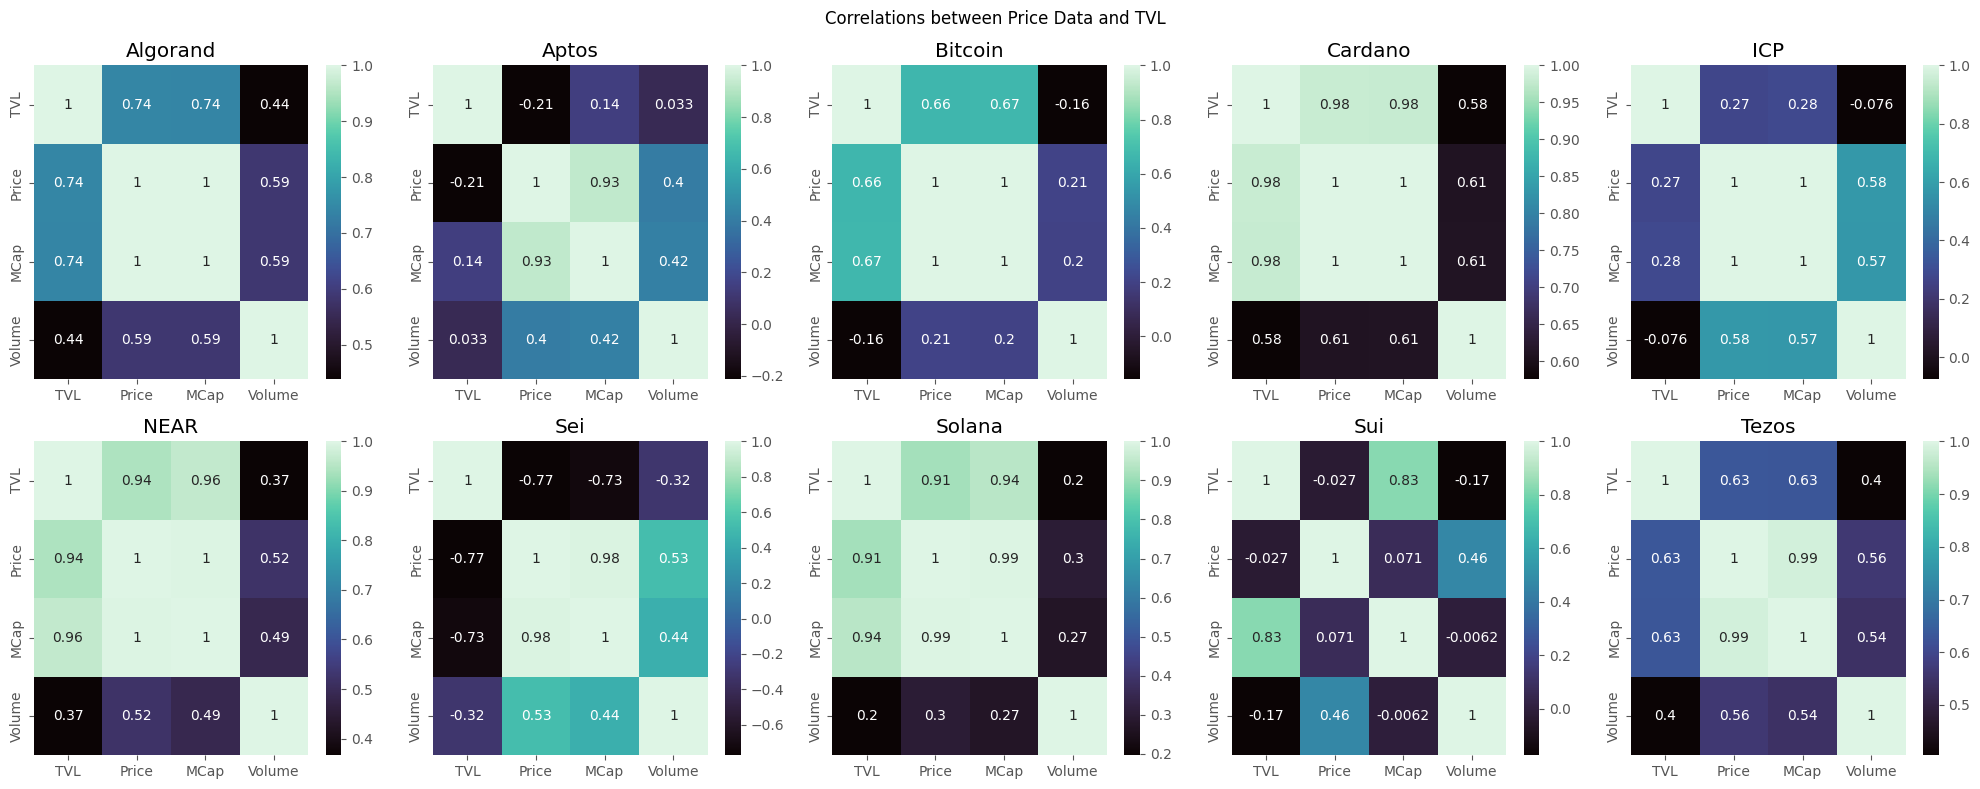

In [76]:
# Create the subplot layout (5 columns, 2 rows)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its heatmap
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    
    # Compute the correlation matrix between TVL and price
    corr_matrix = df[['TVL', 'Price', 
                      'MCap', 'Volume']].corr()
    
    # Plot the heatmap in the corresponding subplot
    sns.heatmap(corr_matrix, annot=True, cmap='mako', ax=axes[i])
    
    # Set title for each subplot
    axes[i].set_title(token)

fig.suptitle('Correlations between Price Data and TVL')
# Adjust the layout
plt.tight_layout()
plt.show()

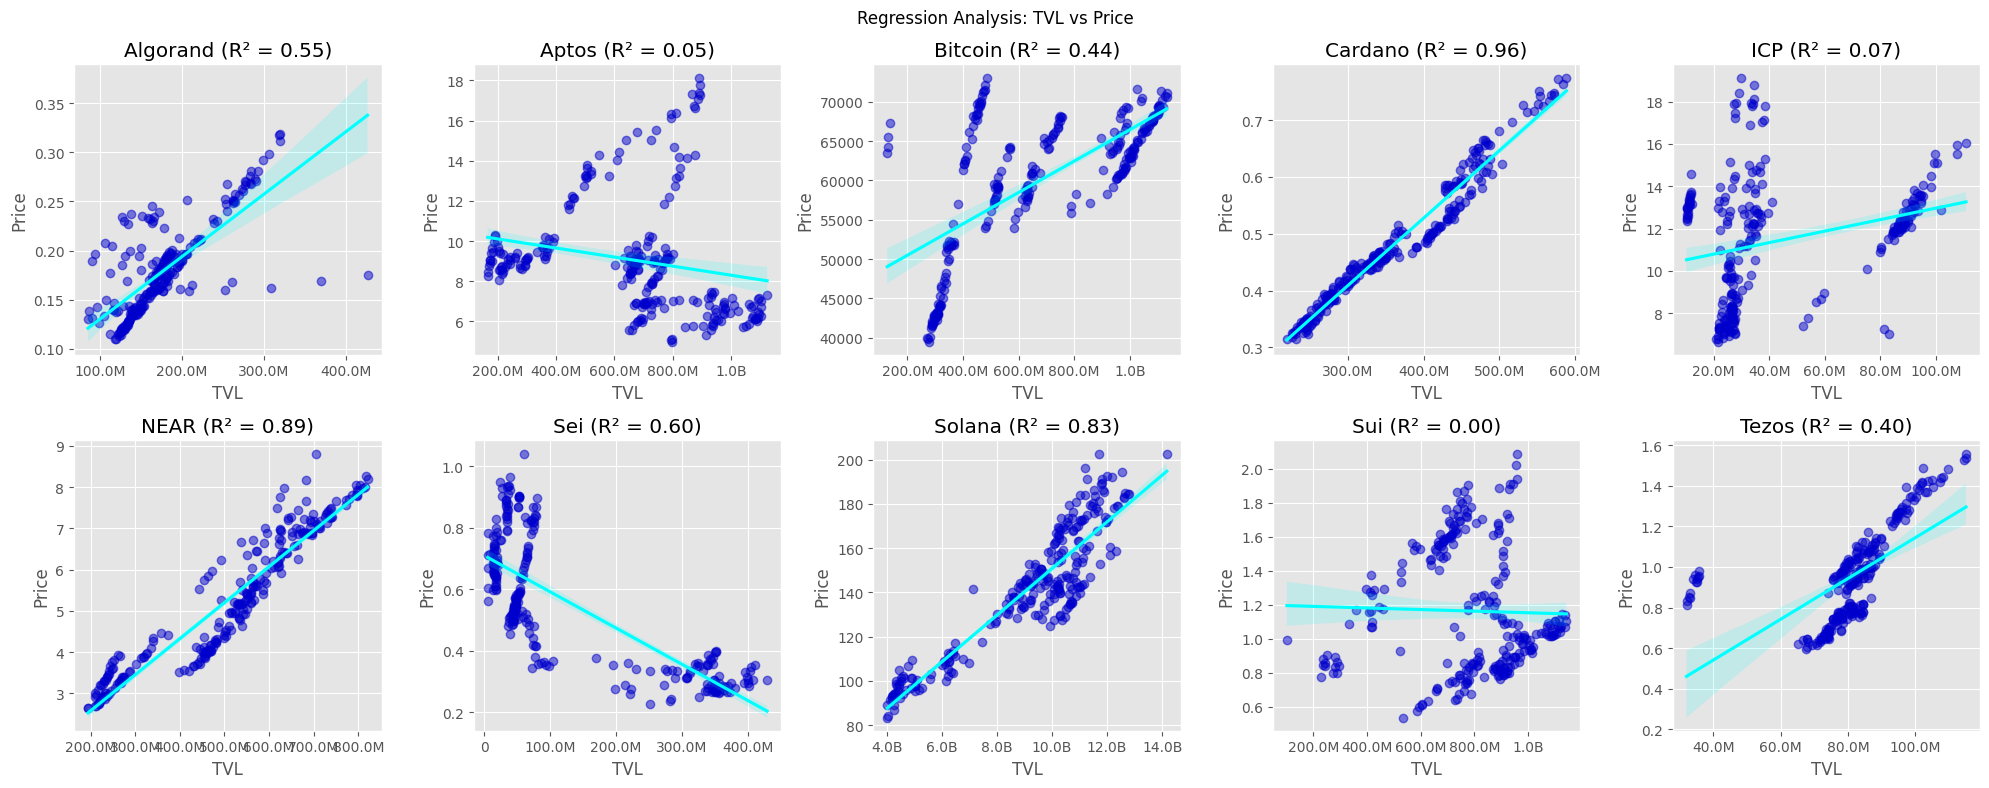

In [102]:

# Create the subplot layout (5 columns, 2 rows)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its scatter plot
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    

    # Extract TVL and Price for the linear regression
    X = df[['TVL']].values  # TVL should be 2D for sklearn
    y = df['Price'].values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values and compute R^2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot the scatter plot with regression line using seaborn
    sns.regplot(x='TVL', y='Price', data=df, ax=axes[i], scatter_kws={'alpha':0.5, 'color': 'mediumblue'}, line_kws={'color':'cyan'})
    
    
    # Plot TVL vs Price (or vice versa)
    #axes[i].scatter(df['Price'], df['TVL'], alpha=0.5, color='mediumblue')
    
    # Set the title and labels
    axes[i].set_title(f'{token} (R² = {r2:.2f})')
    axes[i].set_xlabel('TVL')
    axes[i].set_ylabel('Price')

    # Set custom formatter for both axes to display in 'K', 'M', 'B' format
    #axes[i].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_large_numbers))

fig.suptitle('Regression Analysis: TVL vs Price')
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()